nn-distance SI-cells = 94.96638494793375
nn-distance simulation = 84.42739169864242
p =  0.10228167298836768


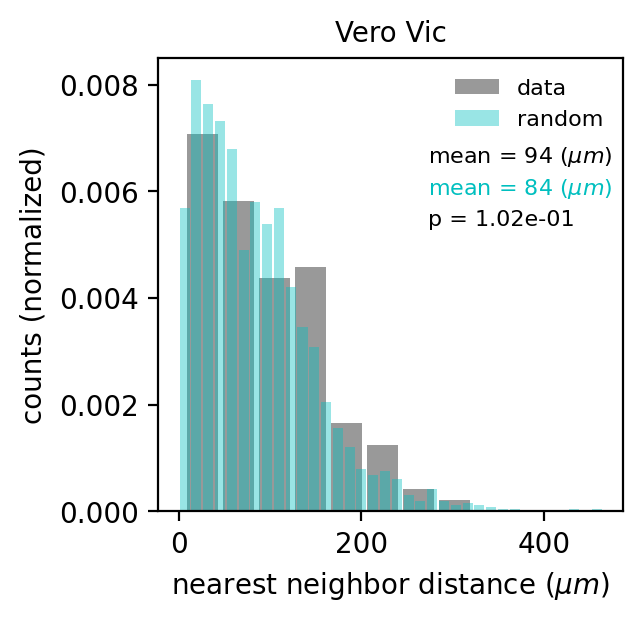

In [20]:
import numpy as np
from numpy import random
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from scipy import stats
from matplotlib.pyplot import figure
from PIL import Image


# specify directory of images
indir = '3D_objects'
infiles = [x for x in os.listdir(indir) if x.endswith('.csv') and not "ADVMLE" in x]
mask_files = [x for x in os.listdir(indir) if x.startswith('Background')]

# Get nn-distances from 3D Object Counter output
nn_distances_data = []
n_SIcells_per_image = []

for file in infiles:
    df = pd.read_csv(os.path.join(indir, file), header=0)
    n_SIcells_per_image.append(df.shape[0])
    
    if df.shape[0] < 2:
        pass
 
    else:
        x_coords = []
        y_coords = []

        for index, row in df.iterrows():
            # find nearest neighbor and calculate distance
            x_coords.append(row['X'])
            y_coords.append(row['Y'])
        centroids = np.column_stack((x_coords, y_coords))

        for index, pt in enumerate(centroids):
            # find nearest neighbor and calculate distance
            distance,index = spatial.KDTree(np.delete(centroids,index, 0)).query(pt)

            # add nearest neighbor amp and dist to a list
            nn_distances_data.append(distance)
        
# Simulate nn-distances for each image
'''
This approach confines the random point search to the exact area where cells
are present in the FOV, using 
1) gets list of pixels in the image that are above background
2) randomly chooses x number of points, where x = the number of superinfected cells
3) repeats 10,000 times
'''
nn_distances_sim = []
n = 0
for mask in mask_files:
    for file in infiles:
        if mask.split('MAX')[1][0:11] in file:
            cell_file = file
            df = pd.read_csv(os.path.join(indir, file), header=0)
    mask_file = os.path.join(indir, mask)
    im = Image.open(mask_file)
    imarray = np.array(im)
    points = np.where(imarray ==1)
    points_list = list(zip(points[0], points[1]))
    n = 0
    
    while n < 10:      
        # select x # of random points, where x = # of superinfected cells
        random_points = []
        p=0
        while p < (df.shape[0]):
            random_points.append(points_list[random.randint(1,len(points_list))])  
            p = p+1
            
        # calculate nn-distance for each random point
        for index, pt in enumerate(random_points):
            # find nearest neighbor and calculate distance
            distance,index = spatial.KDTree(np.delete(random_points,index, 0)).query(pt)

            # add nearest neighbor amp and dist to a list
            nn_distances_sim.append(distance)
        n = n+1
        
    '''
    # Generate a dictionary of random coordinates from a whole image
    points = np.column_stack((random.randint(2048, size=(int(np.mean(n_SIcells_per_image)))),
                              random.randint(2048, size=(int(np.mean(n_SIcells_per_image))))))
    
    for index, pt in enumerate(points):

        # find nearest neighbor and calculate distance
        distance,index = spatial.KDTree(np.delete(points,index, 0)).query(pt)

        # add nearest neighbor amp and dist to a list
        nn_distances_sim.append(distance)
        n = n+1
    '''
    
print('nn-distance SI-cells =', np.mean(np.array(nn_distances_data)*.33))
print('nn-distance simulation =', np.mean(np.array(nn_distances_sim)*.33))

# save dataframe
data_tall = pd.DataFrame(list(zip(nn_distances_data, nn_distances_sim)),
            columns =['nn_distances_data', 'nn_distances_sim'])
data_tall.to_csv('nn_distances.csv')

# Run t-test to compare nn-distances
ttest = stats.ttest_ind(nn_distances_data, nn_distances_sim, equal_var = False)
print ('p = ', ttest[1])

# Plot the data
#figure(figsize=(3, 3), dpi=200)
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

plt.hist(x=np.array(nn_distances_data)*.33, bins='auto', color='black',
                            alpha=.4, rwidth=0.85, density = True, label = 'data')
plt.hist(x=np.array(nn_distances_sim)*.33, bins='auto', color='c',
                            alpha=.4, rwidth=0.85, density = True, label = "random")
#plt.grid(axis='y', alpha=0.75)
plt.xlabel('nearest neighbor distance ($\mu m$)')
plt.ylabel('counts (normalized)')
plt.title('Vero Vic', size = 10)
plt.legend(loc="best", frameon=False, prop={"size":8})
plt.text(.58, .77, "mean = "+str(int(np.mean(nn_distances_data)*.33))+" ($\mu m$)", size = 8, transform = ax.transAxes)
plt.text(.58, .7, "mean = "+str(int(np.mean(nn_distances_sim)*.33))+" ($\mu m$)", size = 8, color = 'c', transform = ax.transAxes)
plt.text(.58, .63, 'p = '+str("{:.2e}".format(ttest[1])), size = 8, transform = ax.transAxes)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.ylim(0,2)

plt.savefig('nn_distances.pdf', bbox_inches='tight')
hypoxic = n_SIcells_per_image

In [23]:
len(nn_distances_data)


122

In [22]:
len(nn_distances_sim)

2040

In [28]:
data_export = pd.DataFrame({'nn_distances_data': pd.Series(nn_distances_data), 'nn_distances_sim': pd.Series(nn_distances_sim)})
data_export.to_csv('Vero_B117_8h_spatial_nn-distances.csv')